In [64]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
import numpy as np

from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f,LogLevel


from torch_openpose.body import Body
from torch_openpose import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

myThread = Thread.thread()
myThread.file_resolver().append('../data/radekData/')
logger = myThread.logger()
logger.set_log_level(LogLevel.Warn)

scene = load_file('../data/radekData/000001.xml')
print("scene loaded")

cuda:0
scene loaded


In [76]:
STRIDE = 8
SPP = 32
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = scene.sensors()[0].film().size()
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

In [77]:
# Render a reference image (no derivatives used yet)
rendering_torch = render_torch(scene, spp=SPP)
print("image rendered")
# make torch RGB to BGR
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
# permute and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

image rendered


In [78]:
heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 391.5, 639.5, -0.5)

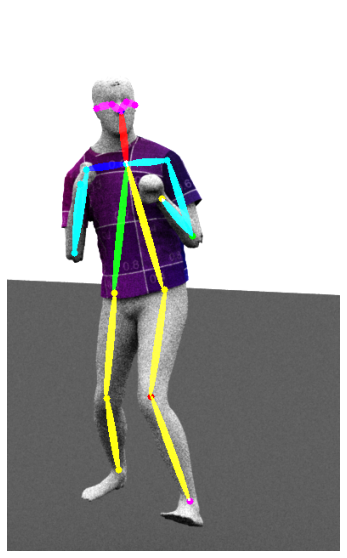

In [79]:
rendering_torch_np =  rendering_torch[:, :, PERMUTE_BGR].cpu().numpy()

canvas = copy.deepcopy(rendering_torch_np)
canvas = util.draw_bodypose(canvas, candidate, subset)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.axis('off')